In [1]:
import numpy as np
import pandas as pd

from pandas_datareader import data as web
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import warnings
warnings.simplefilter('ignore')

import yfinance as yf

from plotly.subplots import make_subplots

from ta.trend import MACD
from ta.momentum import StochasticOscillator

# import talib as ta

In [2]:
stock = 'AAPL'
df = yf.download(tickers=stock, period='1y', interval='1d')

[*********************100%%**********************]  1 of 1 completed


# Conversion Line (Tankan-sen)
  The average of the highest high and lowest low for the preceding 9 periods. It acts as a short-term trend indicator.


In [3]:
high_val = df['High'].rolling(window=9).max()
low_val = df['Low'].rolling(window=9).min()
df['Conversion'] = (high_val + low_val) / 2

# Baseline (Kijun-sen)
  The average of the highest high and lowest low for the preceding 26 periods. It acts as a longer-term trend indicator.

In [4]:
high_val2 = df['High'].rolling(window=26).max()
low_val2 = df['Low'].rolling(window=26).min()
df['Baseline'] = (high_val2 + low_val2) / 2

# Leading Span A (Senkou A)
  The average of the Tenkan-sen and Kijun-sen, plotted 26 periods ahead. It helps identify future areas of support and resistance.


In [5]:
df['SpanA'] = ((df['Conversion'] + df['Baseline']) / 2).shift(26)

# Leading Span B (Senkou B)
  The average of the highest high and lowest low for the preceding 52 periods, plotted 26 periods ahead. Together with Senkou Span A, it forms the "cloud" area on the chart.


In [6]:
high_val3 = df['High'].rolling(window=52).max()
low_val3 = df['Low'].rolling(window=52).min()
df['SpanB'] = ((high_val3 + low_val3) / 2).shift(26)

# Lagging Span (Chikou)
  The current period's closing price, plotted 26 periods behind. It acts as a support/resistance indicator and helps confirm trends.


In [7]:
df['Lagging'] = df['Close'].shift(-26)

# Candlesticks

In [8]:
candle = go.Candlestick(
    x=df.index, 
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name='Candlestick')

In [9]:
# Sets fill color to green when value greater or equal to 1
# and red otherwise
def get_fill_color(label):
    if label >= 1:
        return 'rgba(0,250,0,0.4)'
    else:
        return 'rgba(250,0,0,0.4)'

# Plot

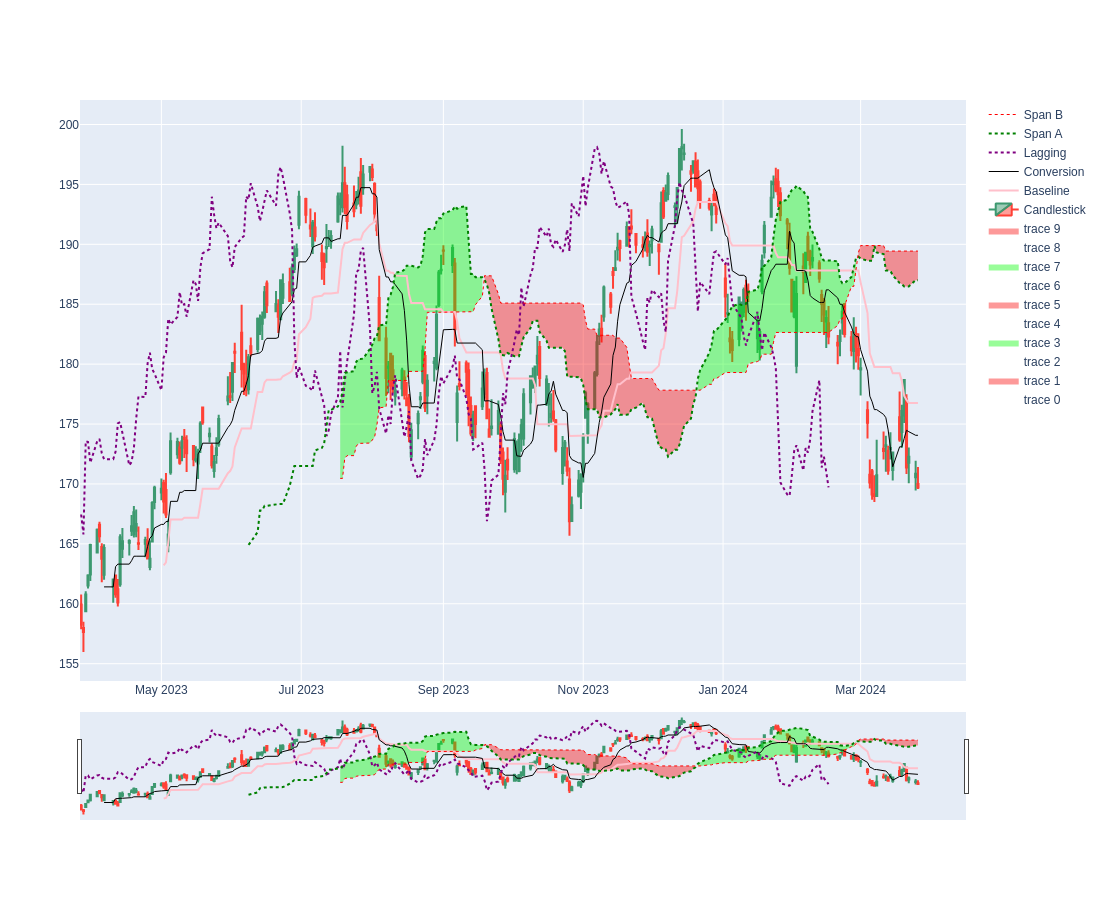

In [10]:
df2 = df.copy()

fig = go.Figure()

df['label'] = np.where (df['SpanA'] > df['SpanB'], 1, 0)

df['group'] = df['label'].ne(df['label'].shift()).cumsum()

df = df.groupby('group')

dfs = []
for name, data in df:
    dfs.append(data)

for dfe in dfs:
    fig.add_traces(go.Scatter(x=dfe.index, 
                              y=dfe.SpanA,
                              line=dict(color='rgba(0,0,0,0)')))
    fig.add_traces(go.Scatter(x=dfe.index, 
                              y=dfe.SpanB,
                              line=dict(color='rgba(0,0,0,0)'),
                              fill='tonexty',
                              fillcolor=get_fill_color(dfe['label'].iloc[0])))
baseline = go.Scatter(x=df2.index, y=df2['Baseline'],
                      line=dict(color='pink', width=2), name='Baseline')
conversion = go.Scatter(x=df2.index, y=df2['Conversion'],
                        line=dict(color='black', width=1), name='Conversion')
lagging = go.Scatter(x=df2.index, y=df2['Lagging'],
                     line=dict(color='purple', width=2, dash='dot'), name='Lagging')
span_a = go.Scatter(x=df2.index, y=df2['SpanA'],
                    line=dict(color='green', width=2, dash='dot'), name='Span A')
span_b = go.Scatter(x=df2.index, y=df2['SpanB'],
                    line=dict(color='red', width=1, dash='dot'), name='Span B')

fig.add_trace(candle)
fig.add_trace(baseline)
fig.add_trace(conversion)
fig.add_trace(lagging)
fig.add_trace(span_a)
fig.add_trace(span_b)

fig.update_layout(height=900, width=1000, showlegend=True)
fig.show()

